In [136]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets        import load_iris, load_breast_cancer
#데이터 분류 함수
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, make_scorer, precision_recall_curve
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.impute          import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing   import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

import seaborn as sns
from io import StringIO
import missingno as msno
import matplotlib.pyplot as plt

### 분류 모델의 성능 평가
- 정확도 : 실 데이터와 예측 데이터가 얼마나 일치하는지를 판단하는 지표
    - 이진분류의 경우 모델의 성능을 왜곡할 수 있음
    - 정확도의 문제점 -- 데이터의 불균형 때문
    - 해결책 -- F1 Score(조합평균) -> Precision, Reacall

In [2]:
#분류모델 성능 평가를 위한 이해
#TP(target = 1, predict = 1)
#TN(target = 0, predict = 0)
#FP(target = 1, predict = 0)  -> 1종 오류(type 1 error)
#FN(target = 0, predict = 1)  -> 2종 오류(type 2 error)

target     = [1, 0, 0, 1, 1, 1, 0, 1, 1, 1]
prediction = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0]

tp = tn = fn = fp = 0
for idx in range(len(target)):
    if target[idx] == 1 and prediction[idx] == 1:
        tp += 1
    elif target[idx] == 0 and prediction[idx] == 0:
        tn += 1
    elif target[idx] == 1 and prediction[idx] == 0:
        fn += 1
    elif target[idx] == 0 and prediction[idx] == 1:
        fp += 1

print("TP(target = 1, predict = 1)", tp)
print("TN(target = 0, predict = 0)", tn)
print("FP(target = 1, predict = 0)", fp)
print("FN(target = 0, predict = 1)", fn)

TP(target = 1, predict = 1) 3
TN(target = 0, predict = 0) 0
FP(target = 1, predict = 0) 3
FN(target = 0, predict = 1) 4


In [3]:
#데이터가 불균형 할 경우 다양한 방법으로 검증을 해야한다.
#기준을 여러개로 둬야한다.

print("accuracy_score - ", accuracy_score(target, prediction))
print("recall_score", recall_score(target, prediction))
print("precision_score", precision_score(target, prediction))
print("f1_score", f1_score(target, prediction))
print()
print("confusion_matrix - \n", confusion_matrix(target, prediction))

accuracy_score -  0.3
recall_score 0.42857142857142855
precision_score 0.5
f1_score 0.4615384615384615

confusion_matrix - 
 [[0 3]
 [4 3]]


- 정밀도(percision) : TP / (FP + TP)
- 상대적으로 정밀도가 더 중요한 지표인 경우의 모델? -> 스팸 메일
- 재현률(recall) : TP / (FN + TP)
- 상대적으로 재현률이 더 즁요한 지표인 경우의 모델? -> 의학(암 진단), 금융(사기 판단)

In [116]:
titanic = pd.read_csv('data/titanic_train.csv')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [117]:
print(titanic['Survived'].value_counts())  # 은근 불균형 함


0    549
1    342
Name: Survived, dtype: int64


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

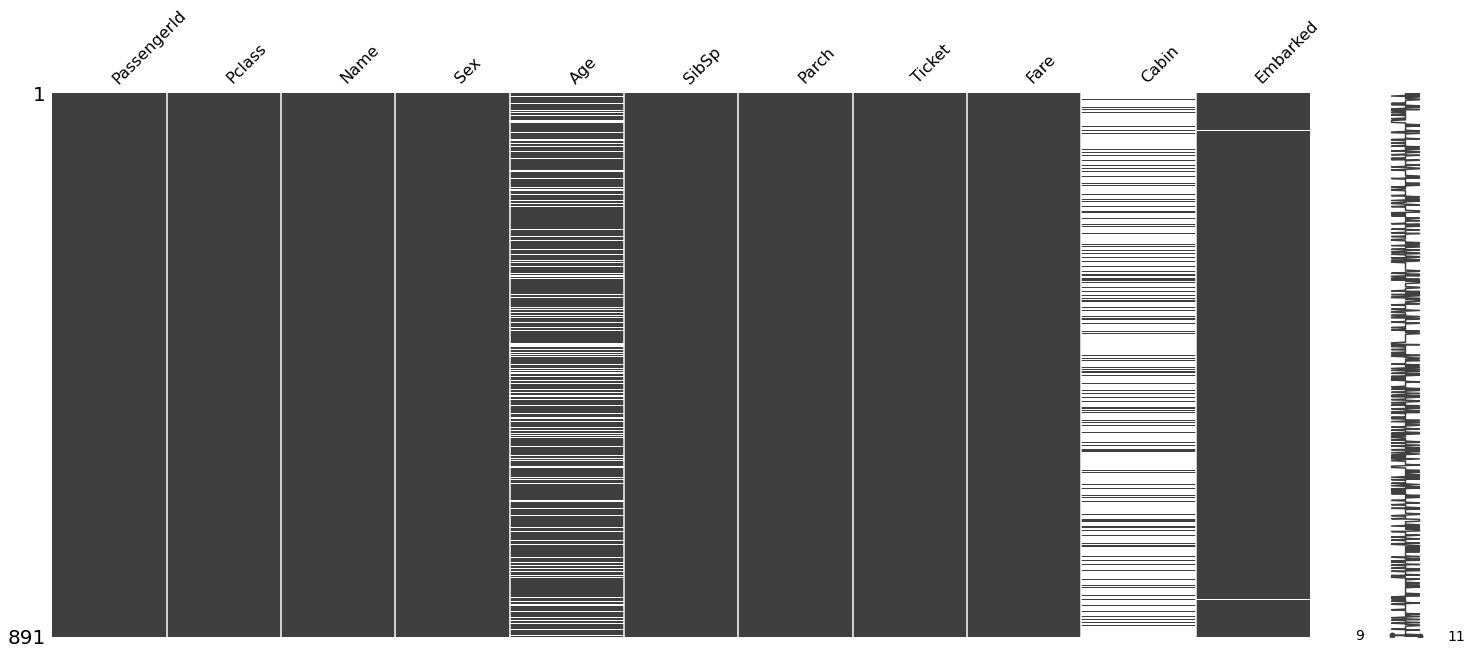

In [140]:
#1번 데이터 분리 - 타겟과 피처로
titanic = pd.read_csv('data/titanic_train.csv')
titanic_target = titanic.loc[:, ['Survived']]
titanic_feature = titanic.drop(['Survived'], axis=1)
print(type(titanic_feature))
print(type(titanic_target))

msno.matrix(titanic_feature)

##### 전처리 요구사항
- 불필요한 피처 제거 -> 'PassengerId', 'Name', 'Ticket'
- 결측치 처리 - 'Age'는 평균으로 대체 / 'Cabin'과 'Embarked' N으로 대체
    - 각자 레이블 인코딩만 진행하는데, 'Cabin'는 숫자 없애고 진행
    - 성별도 레이블 인코딩

In [119]:
#평균 구하기
age_avg = titanic_feature['Age'].mean()
age_avg

29.69911764705882

In [158]:
#데이터 나누기
titanic = pd.read_csv('data/titanic_train.csv')
titanic_target = titanic['Survived']
titanic_feature = titanic.drop(['Survived'], axis=1)

In [159]:
#필요 없는 데이터 제거
titanic_feature.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [160]:
#나이 빈 값을 평균으로 대체
titanic_feature1 = titanic_feature.copy()
titanic_feature2 = titanic_feature1['Age'].fillna(age_avg)
titanic_feature1['Age'] = titanic_feature2
titanic_feature1

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.000000,1,0,7.2500,NaN,S
1,1,female,38.000000,1,0,71.2833,C85,C
2,3,female,26.000000,0,0,7.9250,NaN,S
3,1,female,35.000000,1,0,53.1000,C123,S
4,3,male,35.000000,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...
886,2,male,27.000000,0,0,13.0000,NaN,S
887,1,female,19.000000,0,0,30.0000,B42,S
888,3,female,29.699118,1,2,23.4500,NaN,S
889,1,male,26.000000,0,0,30.0000,C148,C


In [161]:
#Cabin에서 앞 첫 글자 이외의 글자 제거 함수 선언
def del_data(dataframe, column):
    list_data = []
    titanic_feature_test = dataframe[column].astype(str)
#     print(titanic_feature_test)
    for idx, value in enumerate(titanic_feature_test):
        list_data.append(value[0])
    df = pd.DataFrame(list_data, columns=[column])
    return list_data, df

In [162]:
#함수 실행 후 확인
list_data, df = del_data(titanic_feature1, 'Cabin')
print(list_data)
print(type(list_data))
df

['n', 'C', 'n', 'C', 'n', 'n', 'E', 'n', 'n', 'n', 'G', 'C', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'D', 'n', 'A', 'n', 'n', 'n', 'C', 'n', 'n', 'n', 'B', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'D', 'n', 'B', 'C', 'n', 'n', 'n', 'n', 'n', 'B', 'C', 'n', 'n', 'n', 'F', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'F', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'C', 'n', 'n', 'n', 'E', 'n', 'n', 'n', 'A', 'D', 'n', 'n', 'n', 'n', 'D', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'C', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'B', 'n', 'n', 'n', 'n', 'E', 'D', 'n', 'n', 'n', 'F', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'D', 'C', 'n', 'B', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'F', 'n', 'n', 'C', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'E', 'n', 'n', 'n', 'B', 'n', 'n', 'n', 'A', 'n', 'n', 'C', 'n', 'n', 'n', 'n', 'n', 'F', 'n', 'A', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'F', 'B', 'B', 'n', 'n', 'n', 'n',

,Cabin
0,n
1,C
2,n
3,C
4,n
...,...
886,n
887,B
888,n
889,C


In [163]:
titanic_feature1['Cabin'] = list_data
titanic_feature1

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.000000,1,0,7.2500,n,S
1,1,female,38.000000,1,0,71.2833,C,C
2,3,female,26.000000,0,0,7.9250,n,S
3,1,female,35.000000,1,0,53.1000,C,S
4,3,male,35.000000,0,0,8.0500,n,S
...,...,...,...,...,...,...,...,...
886,2,male,27.000000,0,0,13.0000,n,S
887,1,female,19.000000,0,0,30.0000,B,S
888,3,female,29.699118,1,2,23.4500,n,S
889,1,male,26.000000,0,0,30.0000,C,C


In [164]:
titanic_feature1['Cabin'] = pd.DataFrame(list_data, columns=['cabin'])
display(titanic_feature1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.000000,1,0,7.2500,n,S
1,1,female,38.000000,1,0,71.2833,C,C
2,3,female,26.000000,0,0,7.9250,n,S
3,1,female,35.000000,1,0,53.1000,C,S
4,3,male,35.000000,0,0,8.0500,n,S
...,...,...,...,...,...,...,...,...
886,2,male,27.000000,0,0,13.0000,n,S
887,1,female,19.000000,0,0,30.0000,B,S
888,3,female,29.699118,1,2,23.4500,n,S
889,1,male,26.000000,0,0,30.0000,C,C


In [106]:
#함수 실행???
titanic_feature2 = titanic_feature[['Cabin', 'Embarked']].fillna('N')
titanic_feature[['Cabin', 'Embarked']] = titanic_feature2
titanic_feature

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,N,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,N,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,N,S
...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,N,S
887,1,female,19.0,0,0,30.0000,B42,S
888,3,female,NaN,1,2,23.4500,N,S
889,1,male,26.0,0,0,30.0000,C148,C


In [107]:
list_data = del_data(titanic_feature, 'Cabin')
titanic_feature['Cabin'] = pd.DataFrame(list_data, columns=['Cabin'])
display(titanic_feature)

ValueError: 1 columns passed, passed data had 891 columns

In [165]:
#교수님 답

def drop_features(frm):
    frm.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return frm

def pre_processing(frm) :
    frm['Age'].fillna(frm['Age'].mean() , inplace=True)
    frm['Cabin'].fillna('N' , inplace=True)
    frm['Embarked'].fillna('N' , inplace=True)
    return frm

def label_encoder(frm):
    frm['Cabin'] = frm['Cabin'].str[0]
    features = ['Sex', 'Cabin', 'Embarked']
    
    for feature in features:
        encoder = LabelEncoder()
        frm[feature] = encoder.fit_transform(frm[feature])
    return frm

In [166]:
frm = label_encoder(titanic_feature1)
frm

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,7.2500,8,2
1,1,0,38.000000,1,0,71.2833,2,0
2,3,0,26.000000,0,0,7.9250,8,2
3,1,0,35.000000,1,0,53.1000,2,2
4,3,1,35.000000,0,0,8.0500,8,2
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,8,2
887,1,0,19.000000,0,0,30.0000,1,2
888,3,0,29.699118,1,2,23.4500,8,2
889,1,1,26.000000,0,0,30.0000,2,0


<AxesSubplot:>

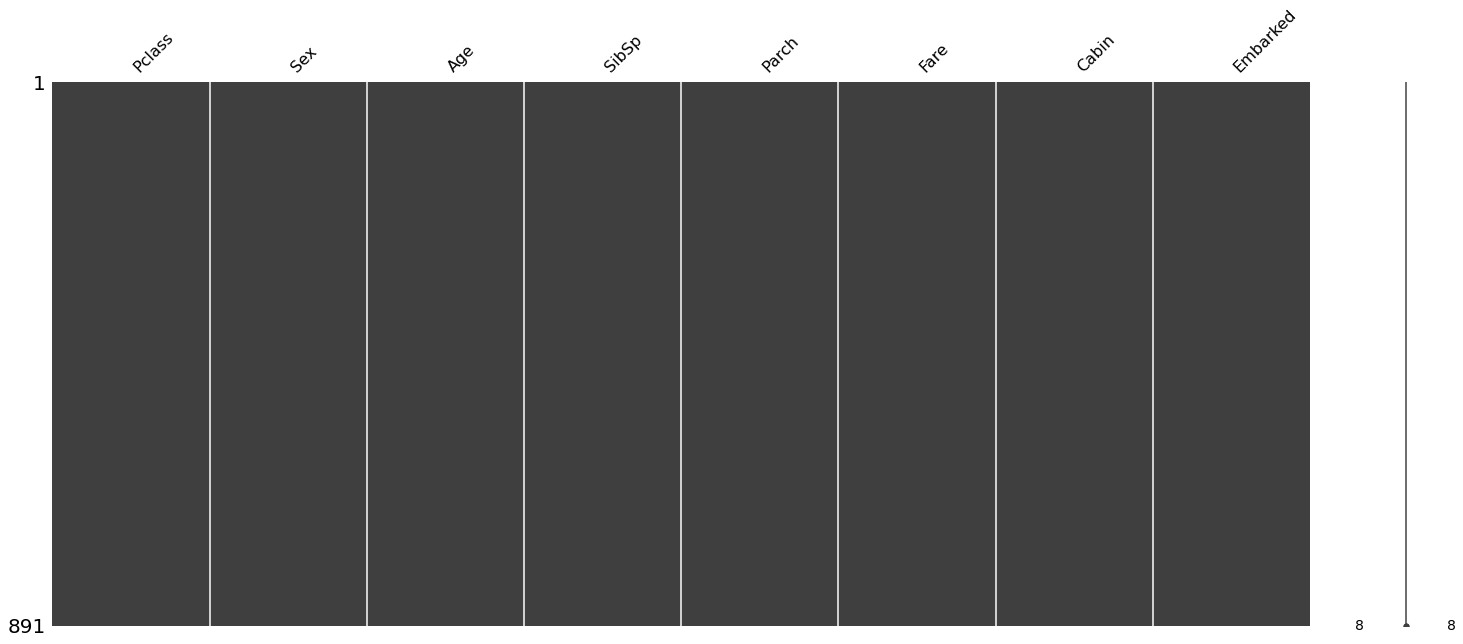

In [167]:
msno.matrix(titanic_feature1)

In [169]:
#데이터 학습 시작

X_train, X_test, y_train, y_test = train_test_split(titanic_feature1,
                                                     titanic_target,
                                                     test_size=0.2,
                                                     random_state=100)
print(type(y_train))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

<class 'pandas.core.series.Series'>


((712, 8), (179, 8), (712,), (179,))

In [170]:
# LogisticRegression 모델
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
print(lr_y_pred.shape)
print(y_test.shape)

(179,)
(179,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [173]:
#DecisionTree 모델
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)

In [174]:
#모델의 정확도, recall, f1 score등의 정보 출력 함수
def metrics_eval(target, prediction) : 
    print('accuracy  - ' , accuracy_score(target, prediction))
    print('recall    - ' , recall_score(target, prediction))
    print('precision - ' , precision_score(target, prediction))
    print('f1 score  - ' , f1_score(target, prediction))
    print()
    print('confusion_matrix - \n' , confusion_matrix(target, prediction))

In [175]:
print("LogisticRegression - ")
print()
metrics_eval(y_test, lr_y_pred)

LogisticRegression - 

accuracy  -  0.8044692737430168
recall    -  0.72
precision -  0.7941176470588235
f1 score  -  0.7552447552447551

confusion_matrix - 
 [[90 14]
 [21 54]]


In [176]:
print("DecisionTreeClassifier - ")
print()
metrics_eval(y_test, dt_y_pred)

DecisionTreeClassifier - 

accuracy  -  0.7821229050279329
recall    -  0.7466666666666667
precision -  0.7368421052631579
f1 score  -  0.7417218543046358

confusion_matrix - 
 [[84 20]
 [19 56]]


In [177]:
#교차 검증 추가 진행
fold = KFold(n_splits=10)
scoring = {
    'accuracy' : make_scorer(accuracy_score),
    'precision_score' : make_scorer(precision_score),
    'recall_score' : make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score),
}

result = cross_validate(lr_model, X_train, y_train,
                       cv = fold,
                       scoring=scoring)
result.keys()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision_score', 'test_recall_score', 'test_f1_score'])

In [178]:
result['test_accuracy'].mean()

0.7894366197183099

#### cancer는 유방암 관련 데이터 - 정확도, 재현률(실제 p를 N 예측하면 안되기 때문에)
- 재현률이란 것은 실제 양성으로 예측한 비율이 높아냐 성능이 좋은 모델임

#### 실습 진행
1. 데이터 프레임 만들기 / 피처와 타겟을 포함한 프레임 제작
2. 타겟에 대한 균형 여부 확인
3. 데이터 세트 분리
4. RandomForestClassifier - 하이퍼 파라미터 튜닝도 가능
5. 평가지표 확인

In [179]:
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [296]:
cancer.target_names

array(['malignant', 'benign'], dtype='<U9')

In [310]:
cancer_df = pd.DataFrame(data=cancer.data,
                        columns=cancer.feature_names)
cancer_feature = cancer_df.copy()
cancer_df['target'] = cancer.target
display(cancer_df)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [321]:
cancer_df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [314]:
# cancer_feature = cancer_df.drop(['target'], axis=1)
cancer_target = pd.Series(cancer.target)
print(type(cancer_target))

#타겟은 시리즈형태, 피처는 데이터 프레임 형태로 나와야함.

<class 'pandas.core.series.Series'>


In [449]:
X_train, X_test, y_train, y_test = train_test_split(cancer_feature,
                                                     cancer_target,
                                                     test_size=0.2,
                                                     random_state=100)
print(type(y_train))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

<class 'pandas.core.series.Series'>


((455, 30), (114, 30), (455,), (114,))

In [450]:
rfc_model = RandomForestClassifier(
                            n_estimators=5,
                            max_features=5,
                            max_depth=20,
                            random_state=0)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=5, n_estimators=5,
                       random_state=0)

In [451]:
rfc_pred = rfc_model.predict(X_test)
print("정확도: {0:.3f}".format(accuracy_score(y_test, rfc_pred)))
metrics_eval(y_test, rfc_pred)
print(type(y_train))
print(y_train.shape)
print(type(rfc_pred))
print(rfc_pred.shape)

정확도: 0.947
accuracy  -  0.9473684210526315
recall    -  0.9846153846153847
precision -  0.927536231884058
f1 score  -  0.9552238805970149

confusion_matrix - 
 [[44  5]
 [ 1 64]]
<class 'pandas.core.series.Series'>
(455,)
<class 'numpy.ndarray'>
(114,)


In [452]:
#교차 검증 추가 진행
fold = KFold(n_splits=20)
scoring = {
    'accuracy' : make_scorer(accuracy_score),
    'precision_score' : make_scorer(precision_score),
    'recall_score' : make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score),
}

result = cross_validate(rfc_model, X_train, y_train,
                       cv = fold,
                       scoring=scoring)
result.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision_score', 'test_recall_score', 'test_f1_score'])

In [456]:
print(result['test_recall_score'].mean())
print(result['test_f1_score'].mean())

0.9689917313079078
0.9596539332791499


#### 재현률을 높이기 위한 방법 - GridSearchCV를 이용한 파라미터 튜닝
- n_estimators - tree 갯수를 의미
- max_feature - 최대 선택할 피처의 갯수를 의미
- max_depth - 최대 선택할 트리의 깊이를 의미

In [457]:
params = {
        'n_estimators' : [50, 100, 150, 200],
        'max_features' : [6, 8, 15, 20],
        'max_depth'    : [4, 6, 8]
}

grid_search_model = GridSearchCV(rfc_model,
                                param_grid=params,
                                cv=20,
                                refit=True,
                                scoring='recall')
grid_search_model.fit(X_train, y_train)

GridSearchCV(cv=20,
             estimator=RandomForestClassifier(max_depth=20, max_features=5,
                                              n_estimators=5, random_state=0),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [6, 8, 15, 20],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='recall')

In [180]:
grid_search_model.cv_results_

NameError: name 'grid_search_model' is not defined

In [ ]:
grid_search_model.best_params_

In [ ]:
grid_search_model.best_score_

In [ ]:
rf_estimator = grid_search_model.best_estimator_


In [ ]:
best_y_pred = rf_estimator.predict(X_test)
metrics_eval(y_test , best_y_pred)

#### 정밀도와 재현률을 임의로 조절하는 모델을 생성해야하는 경우
- 분류 임계 값이 낮을수록 Positive를 예측 할 확률이 높아져 제한률이 증가
    - predict_proba()

In [353]:
matrix = [
    [-1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]
]
from sklearn.preprocessing import Binarizer

In [354]:
holder = Binarizer(threshold=1.1)
print(holder.fit_transform(matrix)) #1.1 기준으로 분류함 작으면0, ,크면 1

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [401]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [408]:
print("확률 예측 값 - ")
predict_proba_result = logistic_model.predict_proba(X_test)
print("타입", type(predict_proba_result))
print("모양", predict_proba_result.shape)
print("타입", type(y_pred))
print("모양", y_pred.shape)

확률 예측 값 - 
타입 <class 'numpy.ndarray'>
모양 (179, 2)
타입 <class 'numpy.ndarray'>
모양 (179,)


In [405]:
predict_proba_result[0:3]

array([[0.16446551, 0.83553449],
       [0.26640653, 0.73359347],
       [0.89458885, 0.10541115]])

In [407]:
y_pred.shape

(179,)

In [410]:
predict_proba_concat = np.concatenate([predict_proba_result, y_pred.reshape(-1,1)], axis=1)
predict_proba_concat[:10]
#확률과 그에 따라 높은 확률의 인덱스가 보여진다.

array([[0.16446551, 0.83553449, 1.        ],
       [0.26640653, 0.73359347, 1.        ],
       [0.89458885, 0.10541115, 0.        ],
       [0.4194012 , 0.5805988 , 1.        ],
       [0.86538409, 0.13461591, 0.        ],
       [0.23591489, 0.76408511, 1.        ],
       [0.89779974, 0.10220026, 0.        ],
       [0.78323474, 0.21676526, 0.        ],
       [0.05940248, 0.94059752, 1.        ],
       [0.64334688, 0.35665312, 0.        ]])

In [415]:
user_th = 0.3
# predict_proba_result[:,1]  #1의 확률만 가져옴
predict_proba_positive = predict_proba_result[:,1].reshape(-1,1)
user_pred = Binarizer(threshold=user_th).fit_transform(predict_proba_positive)

In [416]:
print("디폴트 값")
metrics_eval(y_test, y_pred)
print()
print("쓰레스 홀드 값을 준 predict")
metrics_eval(y_test, user_pred)
print()
#결과적으로 재현률(recall)을 높일 수 있었으며, recall이 높아지면 precision가 낮아짐을 알 수 있다.

디폴트 값
accuracy  -  0.8044692737430168
recall    -  0.72
precision -  0.7941176470588235
f1 score  -  0.7552447552447551

confusion_matrix - 
 [[90 14]
 [21 54]]

쓰레스 홀드 값을 준 predict
accuracy  -  0.7932960893854749
recall    -  0.7733333333333333
precision -  0.7435897435897436
f1 score  -  0.7581699346405228

confusion_matrix - 
 [[84 20]
 [17 58]]



#### trade-off 시각화
- precision_recall_curve(실제값, 확률 값) : 임계값 변화에 따른 평가지표를 반환
- 반환값 : 정밀도, 재현률, 임계 값

In [418]:
import matplotlib.pyplot as plt
%matplotlib inline

In [421]:
predict_proba_positive = predict_proba_result[ :, 1]
precision, recall, th = precision_recall_curve(y_test, predict_proba_positive)

print("precision - type", type(precision))
print("recall - type", type(recall))
print("th - type", type(th))
print()
print("precision - shape", precision.shape)
print("recall - shape", recall.shape)
print("th - shape", th.shape)

precision - type <class 'numpy.ndarray'>
recall - type <class 'numpy.ndarray'>
th - type <class 'numpy.ndarray'>

precision - shape (149,)
recall - shape (149,)
th - shape (148,)


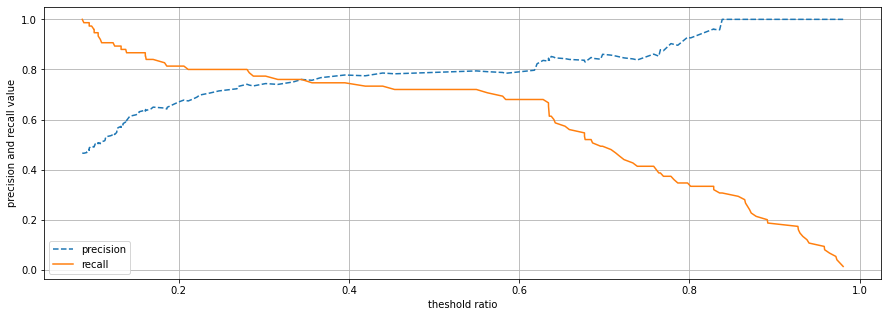

In [428]:
plt.figure(figsize=(15, 5))

plt.plot(th, precision[ 0 : 148] , linestyle="--", label="precision")
plt.plot(th, recall[ 0 : 148]    , linestyle="-" , label="recall")


plt.xlabel('theshold ratio')
plt.ylabel('precision and recall value')

plt.grid()
plt.legend()
plt.show()

In [426]:
th.shape[0]

148